In [1]:
import numpy as np
import kf_recon_deep
import matplotlib.pyplot as plt
from scipy.optimize import minimize

The sign of the probe angle is inferred by the port numbers in the R_PDV/Rapid-Test-Bed/Data_Package_EFP_1_SS/IMG_3660.jpg file. For ports with azimuthal angles away from the main cluster, the probe sign is chosen somewhat arbitrarily to balance the beams.

Initialize the probe angles and values of theta to perform the reconstruction:

In [3]:
probe_signs = np.array([1,1,1,-1,-1,1,-1,-1,1,1,1,1,-1,-1,1,-1])

probes = np.loadtxt(open("../Data/Probe_Angles.txt", "rb"), skiprows=1)[0:16,1]
probes = probes*np.pi/180.*probe_signs
probes = np.delete(probes,[6,9,11])

pred_ang = np.arange(10)*np.pi/9. - np.pi/2.

Read in velocity data from a csv 

For now velocity data should be formatted with 
    - each column as a length n_times vector of time observations
    - order of the columns corresponds to the order of the probe angles above

In [4]:
pdv_vel = np.loadtxt(open("../Data/PDV_traces2.txt", "rb"), skiprows=1)
times   = pdv_vel[:,0]*1.e6
dt      = times[1] - times[0]
pdv_vel = pdv_vel[:,np.arange(1,26,2)]#/1.0e6

In [5]:
# Drop beams that are azimuthally off from the others.
pdv_vel = np.delete(pdv_vel, [2,4,6,7,9],1)
probes  = np.delete(probes,[2,4,6,7,9])


In [6]:
pdv_pos = np.zeros(pdv_vel.shape)
pdv_pos.fill(np.nan)

Set values to _np.nan_ that are places where the probe did not actually have a valid measurement. 

I added a function to the module to do so in a way that seems sensible for the data I've had, but user should do so in the way that makes sense for their application.

The model will treat these as missing values. 

This typically is happening at late times for the probe, where the velocity suddenly drops to negative values.

In [7]:
kf_recon_deep.set_nan(pdv_vel)
pdv_vel /= 1.0e6
pdv_vel *= 1.0e3


Capability for beam offset in progress. For now the offset should be zero.

In [8]:
offsets = np.zeros(8)


Set up the reconstruction parameters. Will be generalize later but for now:
    - How many observations are there in time
    - What is the initial radius of the shell
    - What is the horizontal offset from (0,0) that the probes intersect with the y=0
          - Current below has beams equally spaced over a 0.005 m interval and that grouping is randomly 
              shifted off of center by draw from a random normal with standard dev of 0.01
    - Measured velocities
    - What is the size of the timestep

In [10]:
def fit_ll(params):
    tmp = kf_recon_deep.Reconstruction(n_times      = pdv_vel.shape[0], 
                               init_r       = 0.083997*1.0e3,
                               probe_angles = probes,
                               probe_offset = offsets,
                               pred_angles  = np.arange(2)*np.pi/1. - np.pi/2., 
                               probe_vel    = pdv_vel,
                               probe_pos    = pdv_pos,
                               times        = times,
                               dt           = dt)
    print(params)
    tmp.beta      = 10**params[0]
    tmp.kappa     = 10**params[1]
    tmp.sigsq_vel = 10**params[2]
    tmp.lam       = 10**params[3]
    tmp.lam2      = 10**params[4]
    tmp.lin_scale = 1.0
    tmp.con_scale = 100.
    tmp.fit_model()
    print(-tmp.l_like)
    return -tmp.l_like

In [18]:
parm0 = np.array([np.log10(np.pi/2.0), 
                  np.log10(5.), 
                  np.log10(0.05), 
                  np.log10(np.sqrt(3)/1.), 
                  np.log10(np.sqrt(3)/10.)])
res = minimize(fit_ll, parm0, method='nelder-mead', options={'fatol': 1e-1, 'disp': True})

/Users/mikegros/Projects/PDV_Reconstruction/py_recon/kf_recon_deep.py:149: RuntimeWarning: invalid value encountered in greater
  first_big_vel = np.where( self.probe_vel_orig[:, ii] > 0.100)[0][0]
/Users/mikegros/Projects/PDV_Reconstruction/py_recon/kf_recon_deep.py:150: RuntimeWarning: invalid value encountered in less
  first_peak    = np.where( np.diff( self.probe_vel_orig[first_big_vel:, ii] ) < 0)[0][0] + 1


[ 0.19611988  0.69897    -1.30103     0.23856063 -0.76143937]
-19388.348008704812
[ 0.20592587  0.69897    -1.30103     0.23856063 -0.76143937]
-19390.513054367766
[ 0.19611988  0.7339185  -1.30103     0.23856063 -0.76143937]
-19379.587739141203
[ 0.19611988  0.69897    -1.3660815   0.23856063 -0.76143937]
-21941.362542250183
[ 0.19611988  0.69897    -1.30103     0.25048866 -0.76143937]
-19385.430057690348
[ 0.19611988  0.69897    -1.30103     0.23856063 -0.79951134]
-19401.557887895982
[ 0.20004227  0.6640215  -1.3270506   0.24333184 -0.77666816]
-20423.457738587593
[ 0.20161123  0.6849906  -1.33745884  0.22854108 -0.78275968]
-20832.81279892938
[ 0.20380778  0.67939884 -1.35203037  0.23646129 -0.7912878 ]
-21407.540351641986
[ 0.19315454  0.67157038 -1.37243052  0.23562156 -0.80322717]
-22211.942036082975
[ 0.18676888  0.65787057 -1.40813078  0.23415203 -0.82412106]
-23621.42566128948
[ 0.19922014  0.65513061 -1.41527084  0.23385812 -0.77499908]
-23887.52905688305
[ 0.20077027  0.633

-121724.28383204331
[-0.23156115 -0.74340011 -4.71953624  0.6137214   1.32779425]
-111372.56246501057
[-0.20451571 -0.61700653 -4.43416796  0.58401659  1.19792109]
-111392.0342111781
[-0.06703569 -0.46330877 -4.241546    0.43671552  0.29969213]
-116943.07864484756
[-0.21051861 -0.66737699 -4.59317308  0.59731263  1.18635314]
-115246.93268539164
[-0.1653926  -0.59821653 -4.46540694  0.54602114  0.91328758]
-120680.84479371549
[-0.21284025 -0.64876649 -4.52328     0.59646603  1.2261901 ]
-112084.6333709499
[-0.10348683 -0.5096732  -4.3119795   0.47665314  0.53131662]
-119720.80783053377
[-0.15796294 -0.62876649 -4.57679163  0.52112785  0.78585427]
-124517.28306588257
[-0.17862023 -0.69772901 -4.75346381  0.53072216  0.83858333]
-126997.70029687569
[-0.20117785 -0.68515708 -4.66485312  0.56804156  1.05784048]
-121353.43882710508
[-0.20674145 -0.72221771 -4.72517738  0.56433121  0.97813832]
-124714.23670216728
[-0.18531294 -0.70694122 -4.73339039  0.53104847  0.82947316]
-126894.1141723521

-134637.00927455528
[-0.55800228 -1.86017813 -5.18927197  1.05265576  1.07596282]
-134763.64277172528
[-0.59647316 -1.96544565 -5.16042293  1.1176845   1.14011865]
-134732.59093876687
[-0.64654939 -2.14334994 -5.3083867   1.17221727  1.0750174 ]
-134718.82778004577
[-0.49086845 -1.62635389 -5.2942002   0.9306288   1.13503075]
-133508.89304765224
[-0.58026889 -1.95044547 -5.22512725  1.08167427  1.00964012]
-134503.4664676389
[-0.65688146 -2.13793199 -5.30422017  1.17801172  1.10729775]
-135160.78128238788
[-0.7438352  -2.37579939 -5.35556817  1.29654989  1.16114937]
-134751.1524932415
[-0.699938   -2.24560744 -5.383548    1.23414321  1.17151299]
-135186.15131620195
[-0.79895341 -2.50780596 -5.48822041  1.36692603  1.26502008]
-134009.41433695666
[-0.66944392 -2.13443715 -5.39599221  1.18203408  1.21112084]
-135269.6246492454
[-0.71403144 -2.22643299 -5.48142469  1.23221398  1.3118612 ]
-134672.29283393922
[-0.72941514 -2.3834628  -5.26519581  1.3053819   1.13425327]
-134700.14571810586

-135471.0307065994
[-0.68768311 -2.16167869 -5.31011911  1.20419238  1.15935969]
-135479.65061670687
[-0.6886529  -2.15373367 -5.31008061  1.19958573  1.14995436]
-135486.73492612483
[-0.69197528 -2.16286501 -5.29869481  1.20766429  1.15879486]
-135499.18849104765
[-0.69620844 -2.15934185 -5.28888055  1.20800784  1.15293625]
-135519.08526361955
[-0.69088549 -2.14895839 -5.30304777  1.19904055  1.15072634]
-135510.081257262
[-0.69359349 -2.15428263 -5.28804361  1.2021255   1.13937951]
-135503.67937382395
[-0.6900505  -2.12826196 -5.29180649  1.1893081   1.13504312]
-135523.54225775515
[-0.68942918 -2.10210949 -5.28488792  1.17653934  1.11914262]
-135535.45037790568
[-0.69948904 -2.13161483 -5.28640345  1.19249494  1.12313398]
-135538.91764050483
[-0.70722419 -2.11954445 -5.2778188   1.18793009  1.10384015]
-135543.93209311127
[-0.70228342 -2.11996105 -5.26699085  1.1898716   1.11645559]
-135560.9199224093
[-0.70909868 -2.10307475 -5.24544596  1.18501454  1.0997062 ]
-135573.499301048
[-

-136216.45860262183
[-1.01703301 -1.71757751 -5.3396624   1.11466362  0.97329656]
-136214.57715701903
[-1.00502746 -1.77452426 -5.33972647  1.13567242  0.9896169 ]
-136216.3289473784
[-1.03234108 -1.75691499 -5.34404666  1.13659236  0.9802874 ]
-136214.22182440327
[-1.00151126 -1.75921735 -5.33846925  1.12790643  0.98645378]
-136216.44152043582
[-0.98773034 -1.7630979  -5.3379205   1.12443934  0.98852627]
-136215.40047663552
[-1.01645932 -1.75728635 -5.34061797  1.13199915  0.98365936]
-136216.50561992894
[-1.00143783 -1.77188582 -5.34930223  1.13289301  0.99257358]
-136215.8849021111
[-1.0044555  -1.76632076 -5.34525928  1.13160995  0.9893326 ]
-136216.6373048217
[-1.01583693 -1.76760862 -5.33826613  1.13736561  0.99025377]
-136214.94242230055
[-1.00443687 -1.75999023 -5.34292558  1.12859077  0.98559692]
-136216.8166538454
[-1.01121008 -1.74472152 -5.34429804  1.12452635  0.98307351]
-136216.51336550748
[-1.0186058  -1.75423008 -5.34788677  1.1309403   0.98488452]
-136216.34466602185


-136232.57142393634
[-1.02477565 -1.74088765 -5.33981274  1.10407391  0.98948521]
-136235.27771303168
[-1.01216308 -1.74178005 -5.34141835  1.10081109  0.989366  ]
-136235.74957846533
[-1.01135577 -1.74014542 -5.34080787  1.09252075  0.99124428]
-136239.25102113042
[-1.0198642  -1.73925086 -5.34599943  1.09631797  0.99213368]
-136237.86567502102
[-1.02594479 -1.7497995  -5.34343863  1.0982755   0.99817465]
-136238.4920657535
[-1.02791119 -1.75154056 -5.34259603  1.09685739  0.99828482]
-136241.55066631077
[-1.03645195 -1.75790862 -5.34213137  1.09245842  1.00383576]
-136243.22498195863
[-1.03244522 -1.73541772 -5.33963124  1.07836498  0.9973179 ]
-136240.19918417206
[-1.02564912 -1.7481212  -5.34499067  1.07910114  1.0035973 ]
-136242.1630582417
[-1.03287453 -1.75330612 -5.33840048  1.07997035  1.00553428]
-136241.0377306547
[-1.02956585 -1.74416013 -5.33894602  1.07069075  1.00243716]
-136243.72040339693
[-1.03137638 -1.74134045 -5.33669971  1.05689838  1.00456842]
-136241.84431419376

-136303.1975262172
[-1.09914991 -1.80769172 -5.32916091  1.03488926  1.00451524]
-136302.8246853672
[-1.0868278  -1.82771059 -5.32902631  1.04856189  1.01001021]
-136301.43600392586
[-1.10382173 -1.80287161 -5.32311156  1.02018568  1.00064959]
-136303.31780348715
[-1.11028163 -1.8276313  -5.33016917  1.02955994  1.0117794 ]
-136302.4708702986
[-1.09590678 -1.80466847 -5.32320751  1.02764168  1.00081272]
-136303.24244395303
[-1.11191012 -1.80007685 -5.31909029  1.02293949  0.99650834]
-136303.18626442418
[-1.10918528 -1.80822207 -5.31536459  1.01518416  0.99789985]
-136302.1378692422
[-1.10165876 -1.80782431 -5.32571183  1.02996299  1.00286139]
-136303.42172941804
[-1.09232453 -1.81893592 -5.32808383  1.02994334  1.00844797]
-136302.90071375694
[-1.10701372 -1.80479162 -5.32133867  1.02469045  0.99949325]
-136303.46797363504
[-1.10706245 -1.80590703 -5.32322388  1.02877891  1.00322344]
-136303.070531064
[-1.10175366 -1.80952446 -5.32320903  1.02539835  1.00162559]
-136303.4590699928
[-1

-136303.60873052356
[-1.11043138 -1.80830815 -5.32413176  1.02685863  1.00173541]
-136303.6087133893
[-1.11034336 -1.80819361 -5.32410889  1.0268021   1.00171259]
-136303.60873893945
[-1.11044317 -1.80812784 -5.32407923  1.02672233  1.00167572]
-136303.6087148877
[-1.11034628 -1.80825331 -5.32412554  1.02684509  1.00173128]
-136303.60873630646
[-1.11041898 -1.80825039 -5.32413027  1.0268308   1.00175023]
-136303.60871989914
[-1.11039936 -1.8082367  -5.32412273  1.02682231  1.0017355 ]
-136303.60873971356
[-1.11030452 -1.80822274 -5.32415735  1.02679292  1.00174619]
-136303.60871170947
[-1.11040543 -1.80822603 -5.32410476  1.02682161  1.00171665]
-136303.60874305942
Optimization terminated successfully.
         Current function value: -136303.608743
         Iterations: 446
         Function evaluations: 715


In [9]:
res = {"x":np.array([-1.11040543, -1.80822603, -5.32410476,  1.02682161,  1.00171665])}

In [10]:
print('Spatial Correlation Length: ', (10**res['x'][0])/np.pi*180)
print('Kappa: ', (10**res['x'][1]) )
print('Error Standard Deviation: ', np.sqrt(10**res['x'][2]) )
print('Temporal Correlation Length: ', np.sqrt(3)/10**res['x'][3] )
print('Temporal Correlation Length: ', np.sqrt(3)/10**res['x'][4] )


Spatial Correlation Length:  4.443418331650104
Kappa:  0.015551560348410175
Error Standard Deviation:  0.002177447135907056
Temporal Correlation Length:  0.16283172261860612
Temporal Correlation Length:  0.17252179867574433


In [11]:
small_theta_range = (1.2*np.min(probes)*180./np.pi, 1.2*np.max(probes)*180./np.pi)


In [37]:
pred_ang = np.arange(120)*np.pi/119. - np.pi/2.

In [38]:
surf_opt = kf_recon_deep.Reconstruction(n_times      = pdv_vel.shape[0], 
                                        init_r       = 0.083997*1.0e3,
                                        probe_angles = probes,
                                        probe_offset = offsets,
                                        pred_angles  = pred_ang, 
                                        probe_vel    = pdv_vel,
                                        probe_pos    = pdv_pos,
                                        times        = times,
                                        dt           = dt)

/Users/mikegros/Projects/PDV_Reconstruction/py_recon/kf_recon_deep.py:149: RuntimeWarning: invalid value encountered in greater
  first_big_vel = np.where( self.probe_vel_orig[:, ii] > 0.100)[0][0]
/Users/mikegros/Projects/PDV_Reconstruction/py_recon/kf_recon_deep.py:150: RuntimeWarning: invalid value encountered in less
  first_peak    = np.where( np.diff( self.probe_vel_orig[first_big_vel:, ii] ) < 0)[0][0] + 1


In [39]:
surf_opt.beta      = 10**res['x'][0]
surf_opt.kappa     = 10**res['x'][1]
surf_opt.sigsq_vel = 10**res['x'][2]
surf_opt.lam       = 10**res['x'][3]
surf_opt.lam2      = 10**res['x'][4]


In [42]:
surf_opt.fit_model()

1

In [43]:
surf_opt.l_like

136305.900378723

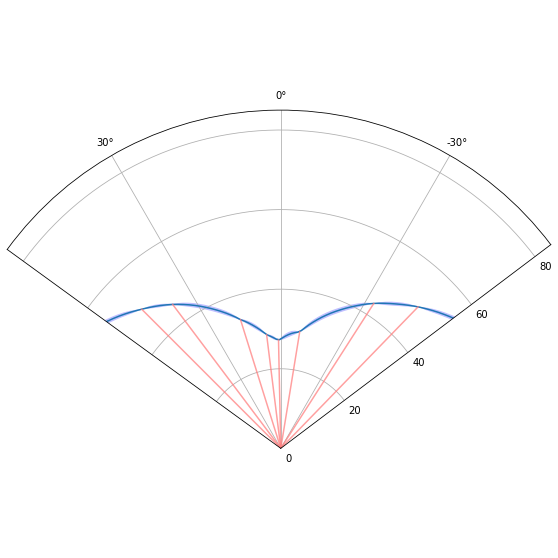

35.00052


In [44]:
surf_opt.plot_surface(t=5267,figsize=(10,10), theta_range=small_theta_range)
print(times[5267])

15.0018
25.001160000000002
35.00052


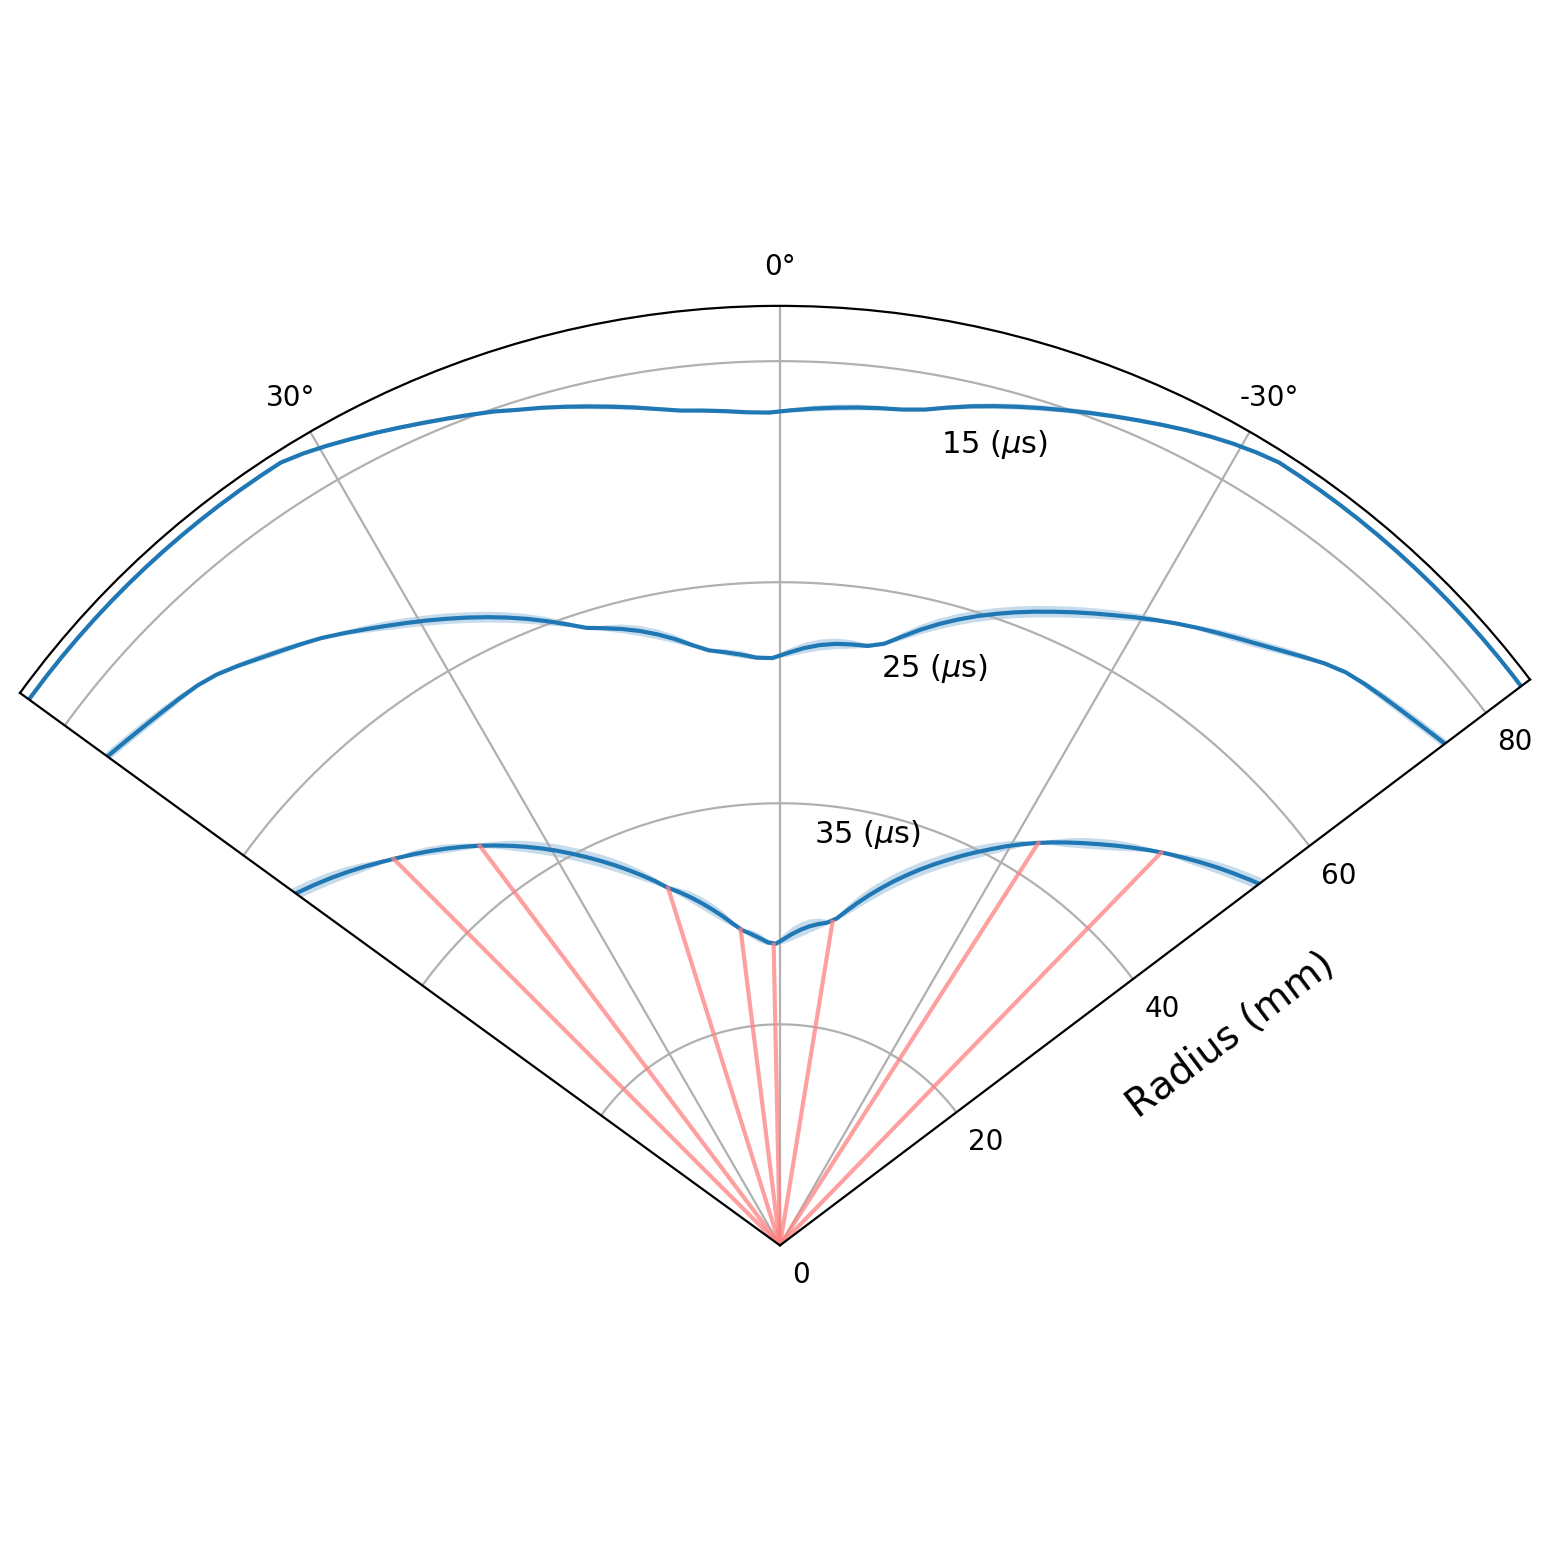

In [73]:
theta_range = small_theta_range
inds   = np.arange(surf_opt.n_pred) + surf_opt.n_probe

fig  = plt.figure(figsize=(10,10),dpi=200)
ax   = fig.add_subplot(111, polar=True)

t = 1361
print(times[t])
ax.plot(surf_opt.pred_angles, surf_opt.pos_mean[inds, t], c="C0")
ax.fill_between(surf_opt.pred_angles,
                surf_opt.pos_mean[inds, t] - 2 * np.sqrt(surf_opt.pos_var[inds,t]),
                surf_opt.pos_mean[inds, t] + 2 * np.sqrt(surf_opt.pos_var[inds,t]),
                alpha       = 0.25,
                facecolor   = 'C0',
                interpolate = True)

t = 3314
print(times[t])
ax.plot(surf_opt.pred_angles, surf_opt.pos_mean[inds, t], c="C0")
ax.fill_between(surf_opt.pred_angles,
                surf_opt.pos_mean[inds, t] - 2 * np.sqrt(surf_opt.pos_var[inds,t]),
                surf_opt.pos_mean[inds, t] + 2 * np.sqrt(surf_opt.pos_var[inds,t]),
                alpha       = 0.25,
                facecolor   = 'C0',
                interpolate = True)

t = 5267
print(times[t])
surface_mean = surf_opt.pos_mean[inds, t]

ax.plot(surf_opt.pred_angles, surface_mean, c="C0")

ax.set_rorigin(0)
ax.set_theta_offset(np.pi/2)
ax.set_thetagrids(np.arange(-90, 90, 30))
ax.set_thetamin(theta_range[0])
ax.set_thetamax(theta_range[1])
ax.set_ylim(0, 0.085*1.0e3)
ax.set_yticks(np.arange(0, 0.085*1.0e3, 0.02*1.0e3))

ax.fill_between(surf_opt.pred_angles,
                surf_opt.pos_mean[inds, t] - 2 * np.sqrt(surf_opt.pos_var[inds,t]),
                surf_opt.pos_mean[inds, t] + 2 * np.sqrt(surf_opt.pos_var[inds,t]),
                alpha       = 0.25,
                facecolor   = 'C0',
                interpolate = True)

for ii in range(surf_opt.n_probe):
    p1 = kf_recon_deep.skew_polar_to_polar(0, surf_opt.probe_angles[ii], surf_opt.probe_offset[ii])
    ax.plot([p1[1], surf_opt.obs_angles[ii, t]], [p1[0], surf_opt.pos_mean[ii, t]],
            color='#ff8080', alpha=0.75)
ax.text(np.radians(-65.),45.,r"Radius (mm)",
        rotation=90 + small_theta_range[0],ha='center',va='center',fontsize=14)
ax.text(np.radians(-15.),75.,r"15 ($\mu$s)",
        rotation=0,ha='center',va='center',fontsize=11)
ax.text(np.radians(-15.),54.,r"25 ($\mu$s)",
        rotation=0,ha='center',va='center',fontsize=11)
ax.text(np.radians(-12.),38.,r"35 ($\mu$s)",
        rotation=0,ha='center',va='center',fontsize=11)
plt.show()


(-800, 800)

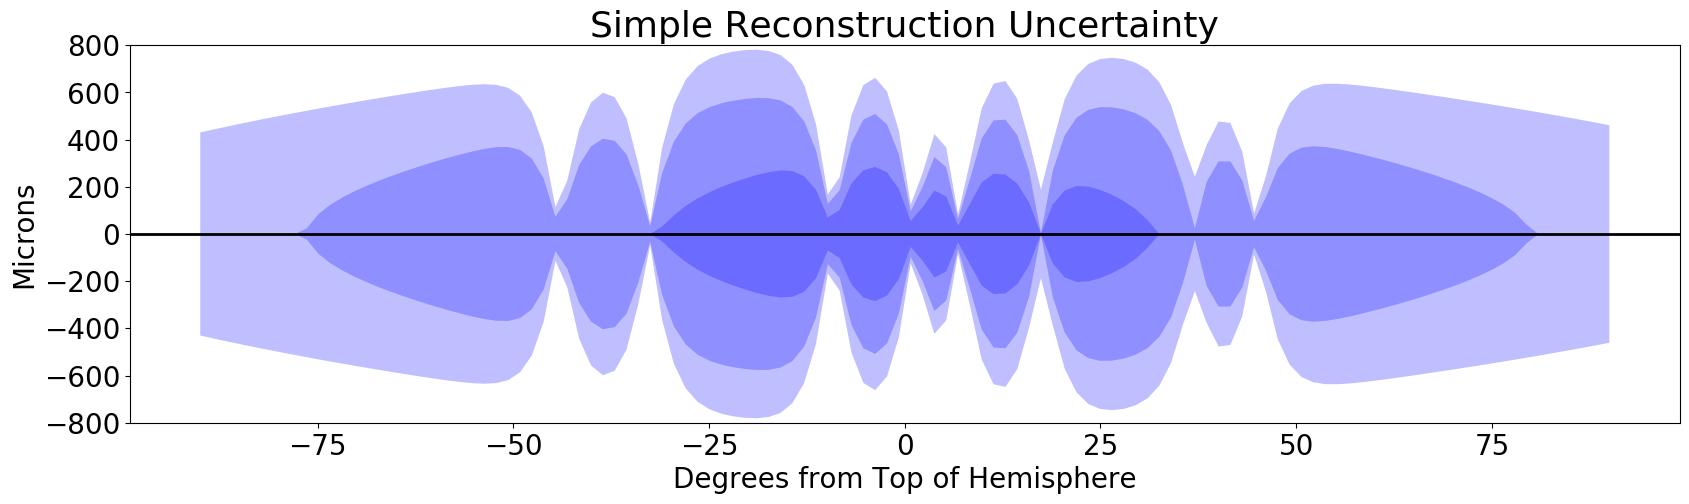

In [78]:
fig  = plt.figure(figsize=(20, 5),dpi=100)
inds = np.arange(surf_opt.n_pred) + surf_opt.n_probe
plt.fill_between(surf_opt.pred_angles*180/np.pi,
                 -2 * np.sqrt(surf_opt.pos_var[inds,5267])*1000,
                 2 * np.sqrt(surf_opt.pos_var[inds,5267])*1000,
                 alpha       = 0.25,
                 facecolor   = 'b',
                 interpolate = True)
plt.fill_between(surf_opt.pred_angles*180/np.pi,
                 -2 * np.sqrt(surf_opt.pos_var[inds,3314])*1000,
                 2 * np.sqrt(surf_opt.pos_var[inds,3314])*1000,
                 alpha       = 0.25,
                 facecolor   = 'b',
                 interpolate = True)
plt.fill_between(surf_opt.pred_angles*180/np.pi,
                 -2 * np.sqrt(surf_opt.pos_var[inds,1361])*1000,
                 2 * np.sqrt(surf_opt.pos_var[inds,1361])*1000,
                 alpha       = 0.25,
                 facecolor   = 'b',
                 interpolate = True)
plt.xlabel("Degrees from Top of Hemisphere", fontsize=20)
plt.ylabel("Microns", fontsize=20)
plt.title("Simple Reconstruction Uncertainty", fontsize=26)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(0,c="k", linewidth=2)
plt.ylim(-800,800)


(-800, 800)

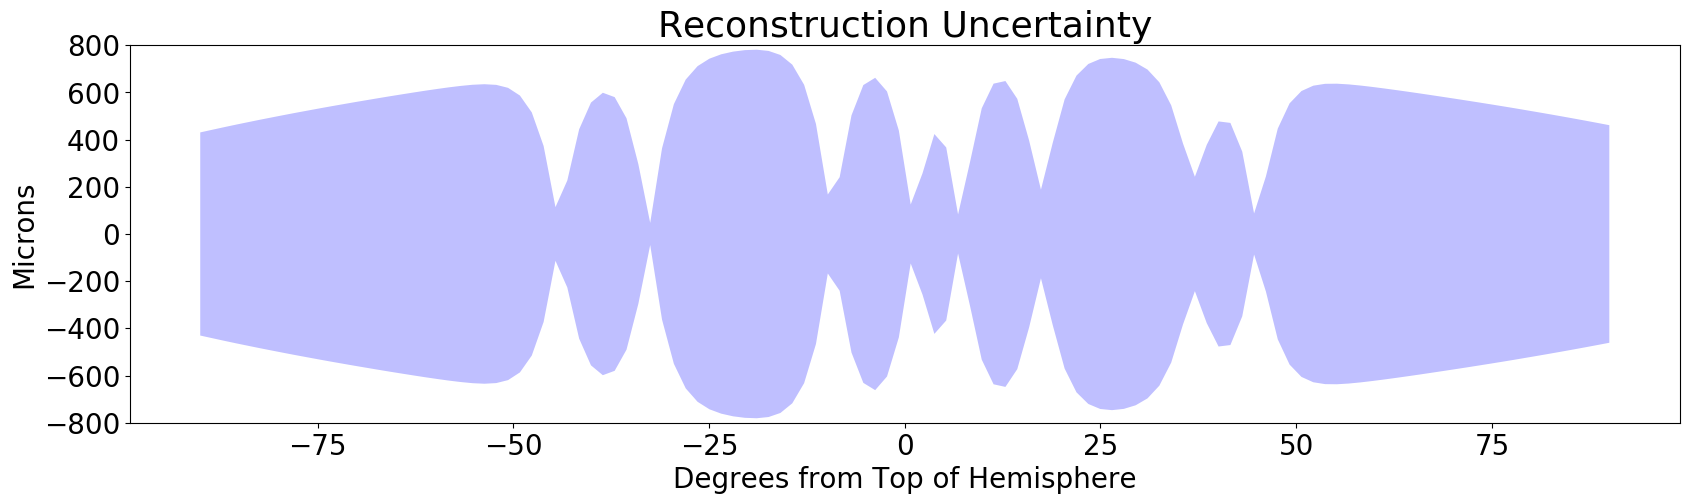

In [48]:
fig  = plt.figure(figsize=(20, 5),dpi=100)
inds = np.arange(surf_opt.n_pred) + surf_opt.n_probe
plt.fill_between(surf_opt.pred_angles*180/np.pi,
                 -2 * np.sqrt(surf_opt.pos_var[inds,5267])*1000,
                 2 * np.sqrt(surf_opt.pos_var[inds,5267])*1000,
                 alpha       = 0.25,
                 facecolor   = 'b',
                 interpolate = True)
plt.xlabel("Degrees from Top of Hemisphere", fontsize=20)
plt.ylabel("Microns", fontsize=20)
plt.title("Reconstruction Uncertainty", fontsize=26)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(-800,800)


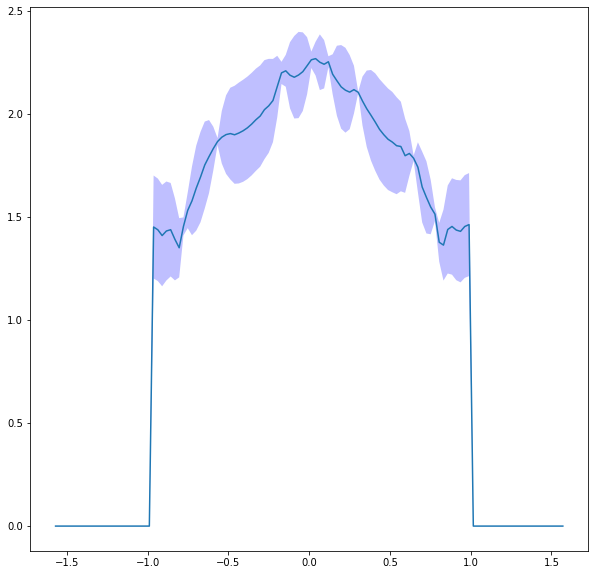

In [49]:
surf_opt.plot_velocity(2400,figsize=(10,10))

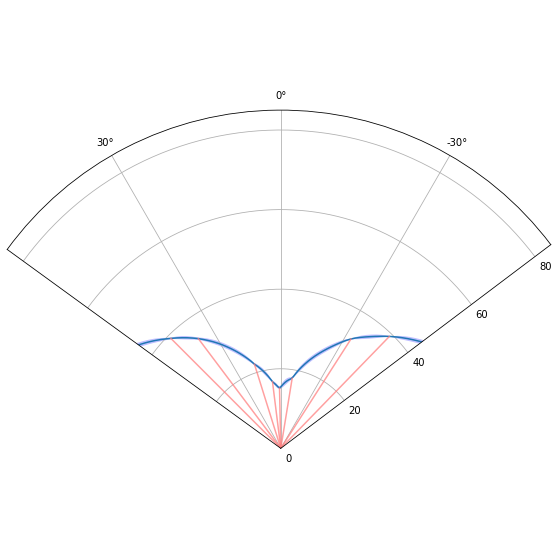

In [50]:
surf_opt.plot_surface(pdv_vel.shape[0]-1,
                      figsize     = (10,10), 
                      theta_range = small_theta_range)

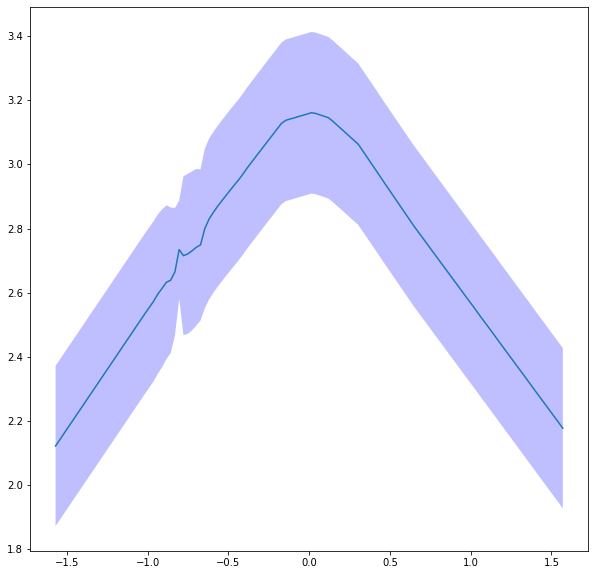

In [51]:
surf_opt.plot_velocity(pdv_vel.shape[0]-1,figsize=(10,10))

In [52]:
np.diff(np.sort(surf_opt.probe_angles))*180./np.pi

array([11.443477, 23.469042, 10.431739,  5.900562, 10.279206, 19.537128,
        8.067674])

In [53]:
np.sort(surf_opt.probe_angles)*180./np.pi

array([-44.141322, -32.697845,  -9.228803,   1.202936,   7.103498,
        17.382704,  36.919832,  44.987506])

In [54]:
np.argsort(surf_opt.probe_angles)

array([7, 5, 2, 0, 1, 3, 4, 6])

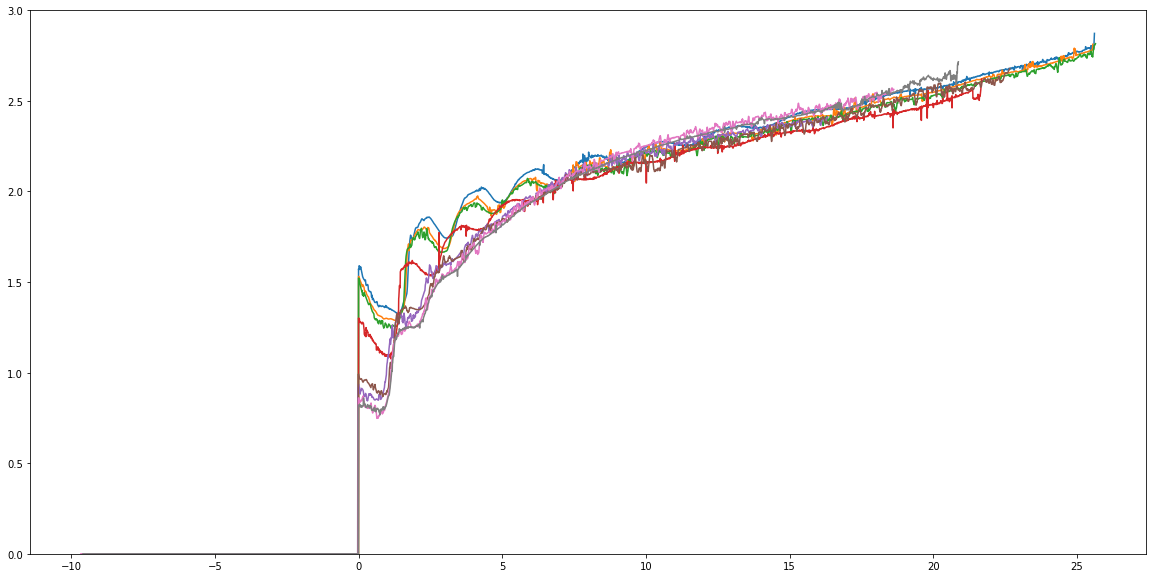

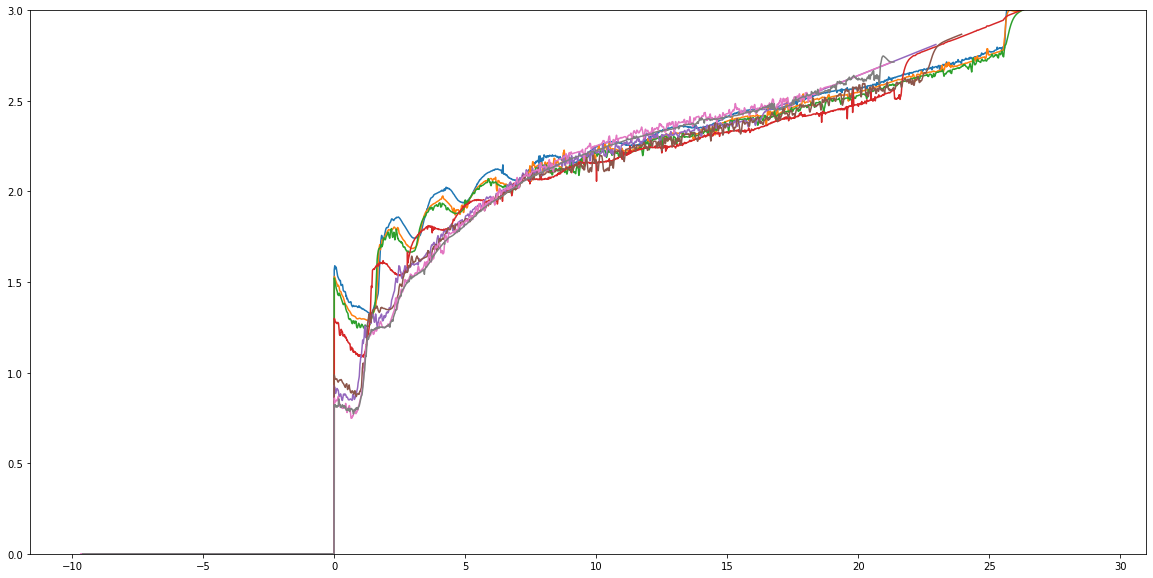

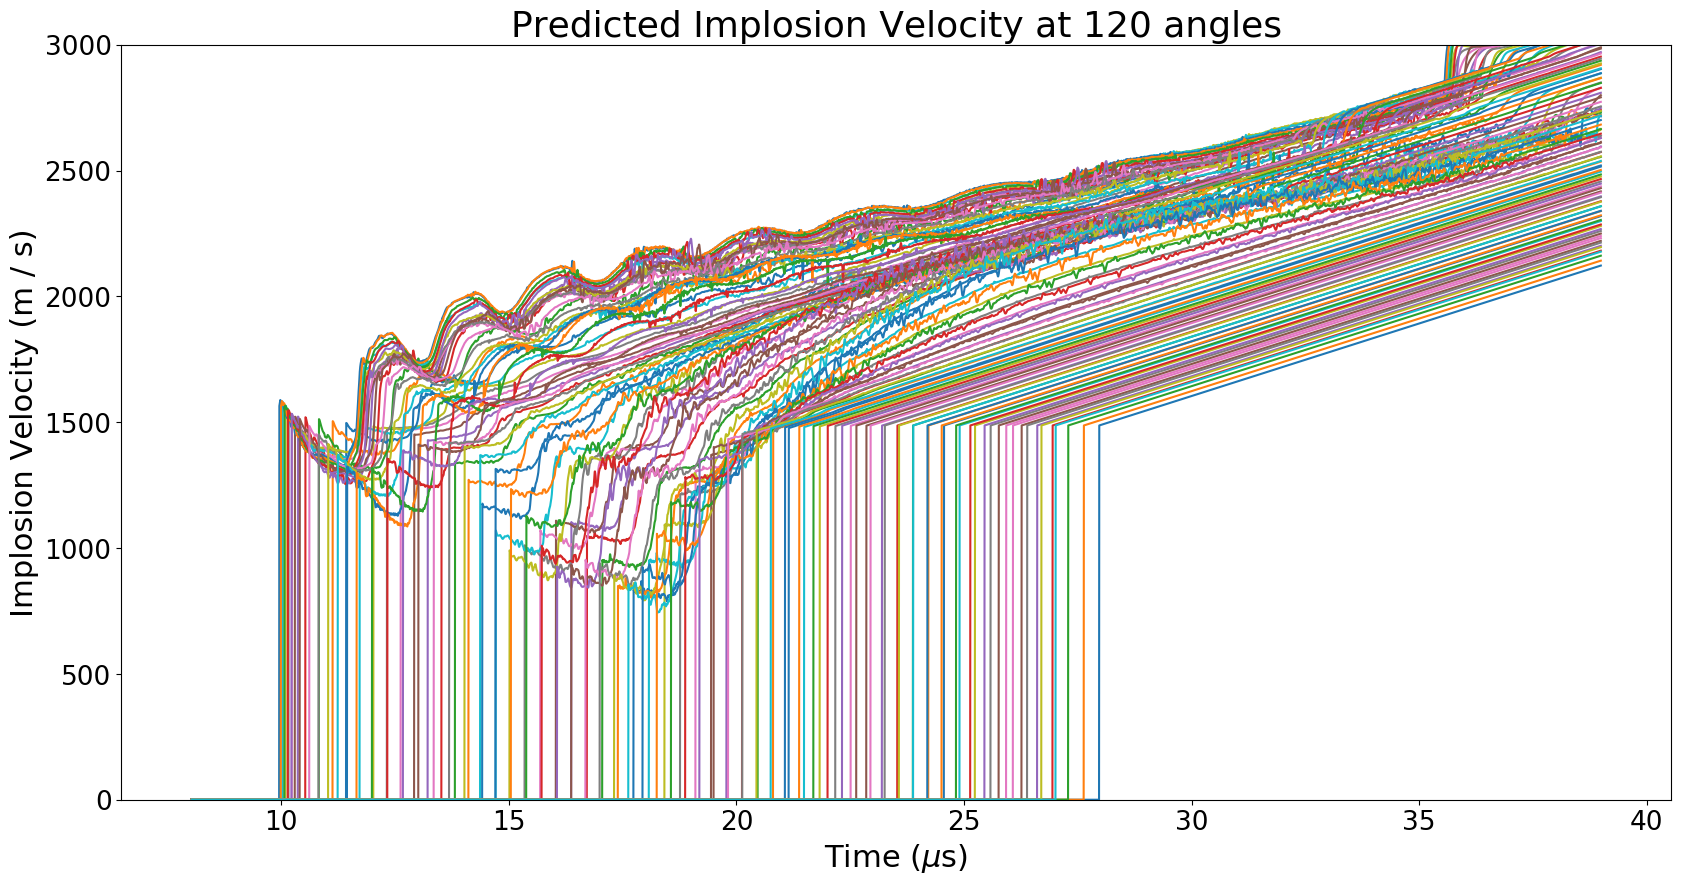

In [61]:
fig  = plt.figure(figsize=(20, 10))
fig.add_subplot(111)
for jj in range(8):
    plt.plot(surf_opt.times - surf_opt.jump_times(surf_opt.probe_angles[jj]), pdv_vel[:,jj])
plt.ylim([0,3])
plt.show()

fig  = plt.figure(figsize=(20, 10))
fig.add_subplot(111)
for jj in range(surf_opt.n_probe):
    plt.plot(surf_opt.times - surf_opt.jump_times(surf_opt.probe_angles[jj]) ,
             surf_opt.vel_mean[jj,:])
plt.ylim([0,3])
plt.show()

fig  = plt.figure(figsize=(20, 10),dpi=100)
fig.add_subplot(111)
for jj in range(surf_opt.n_pred):
    plt.plot(surf_opt.times, 1000*surf_opt.vel_mean[surf_opt.n_probe + jj,:])
plt.xlabel(r"Time ($\mu$s)",fontsize=22)
plt.ylabel(r"Implosion Velocity (m / s)",fontsize=22)
plt.title("Predicted Implosion Velocity at 120 angles", fontsize=26)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.ylim([0,3000])
plt.show()

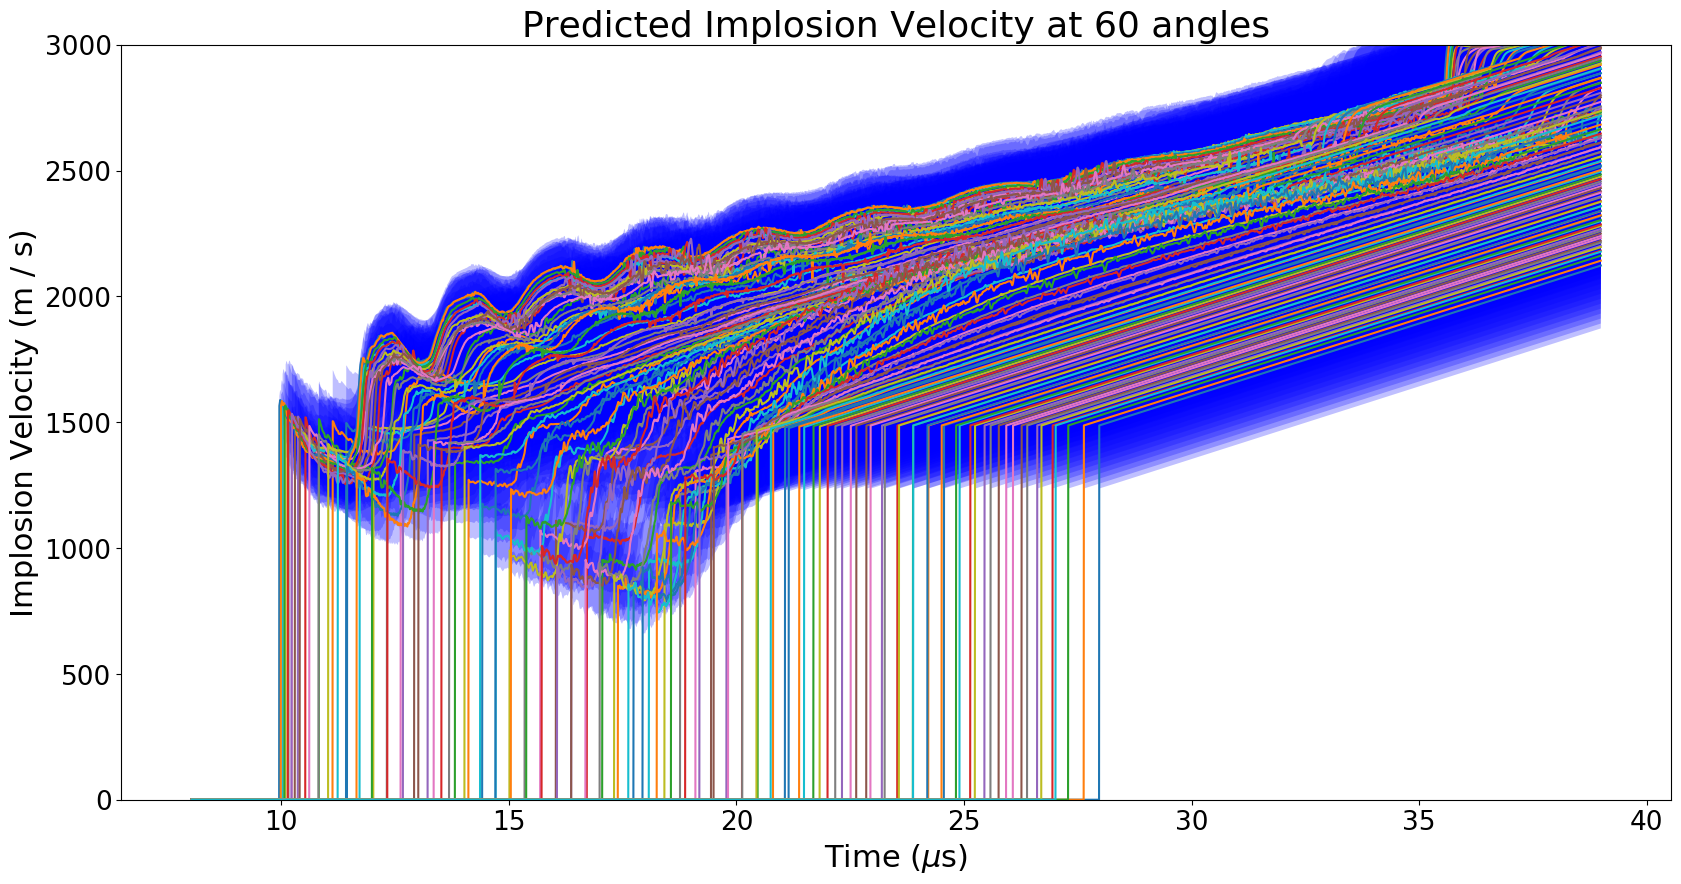

In [56]:
fig  = plt.figure(figsize=(20, 10),dpi=100)
fig.add_subplot(111)
for jj in range(surf_opt.n_pred):
    plt.plot(surf_opt.times, 1000*surf_opt.vel_mean[surf_opt.n_probe + jj,:])
    plt.fill_between(surf_opt.times,
                     1000*(surf_opt.vel_mean[jj, :] + 2 * np.sqrt(surf_opt.vel_var[jj,:])),
                     1000*(surf_opt.vel_mean[jj, :] - 2 * np.sqrt(surf_opt.vel_var[jj,:])),
                     alpha       = 0.25, 
                     facecolor   = 'b', 
                     interpolate = True)
plt.xlabel(r"Time ($\mu$s)",fontsize=22)
plt.ylabel(r"Implosion Velocity (m / s)",fontsize=22)
plt.title("Predicted Implosion Velocity at 60 angles", fontsize=26)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.ylim([0,3000])
plt.show()

In [57]:
import matplotlib as mpl

import numpy as np

from xml.dom import minidom


In [58]:
'''
NAME
    Custom Colormaps for Matplotlib
PURPOSE
    This program shows how to implement make_cmap which is a function that
    generates a colorbar.  If you want to look at different color schemes,
    check out https://kuler.adobe.com/create.
PROGRAMMER(S)
    Chris Slocum
REVISION HISTORY
    20130411 -- Initial version created
    20140313 -- Small changes made and code posted online
    20140320 -- Added the ability to set the position of each color
    
Python - Custom Colormaps for Matplotlib by Chris Slocum is licensed under a Creative Commons Attribution-NonCommercial-NoDerivs 3.0 Unported License.
'''

def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap

## load source xml file

xmldoc = minidom.parse("/Users/mikegros/Downloads/4w_ROTB.xml")
itemlist = xmldoc.getElementsByTagName('Point')

data_vals=[]

color_vals=[]

for s in itemlist:

    data_vals.append(float(s.attributes['x'].value))

    color_vals.append((float(s.attributes['r'].value),
                       float(s.attributes['g'].value),
                       float(s.attributes['b'].value)))

## construct the colormap

mycmap = make_cmap(color_vals,data_vals)


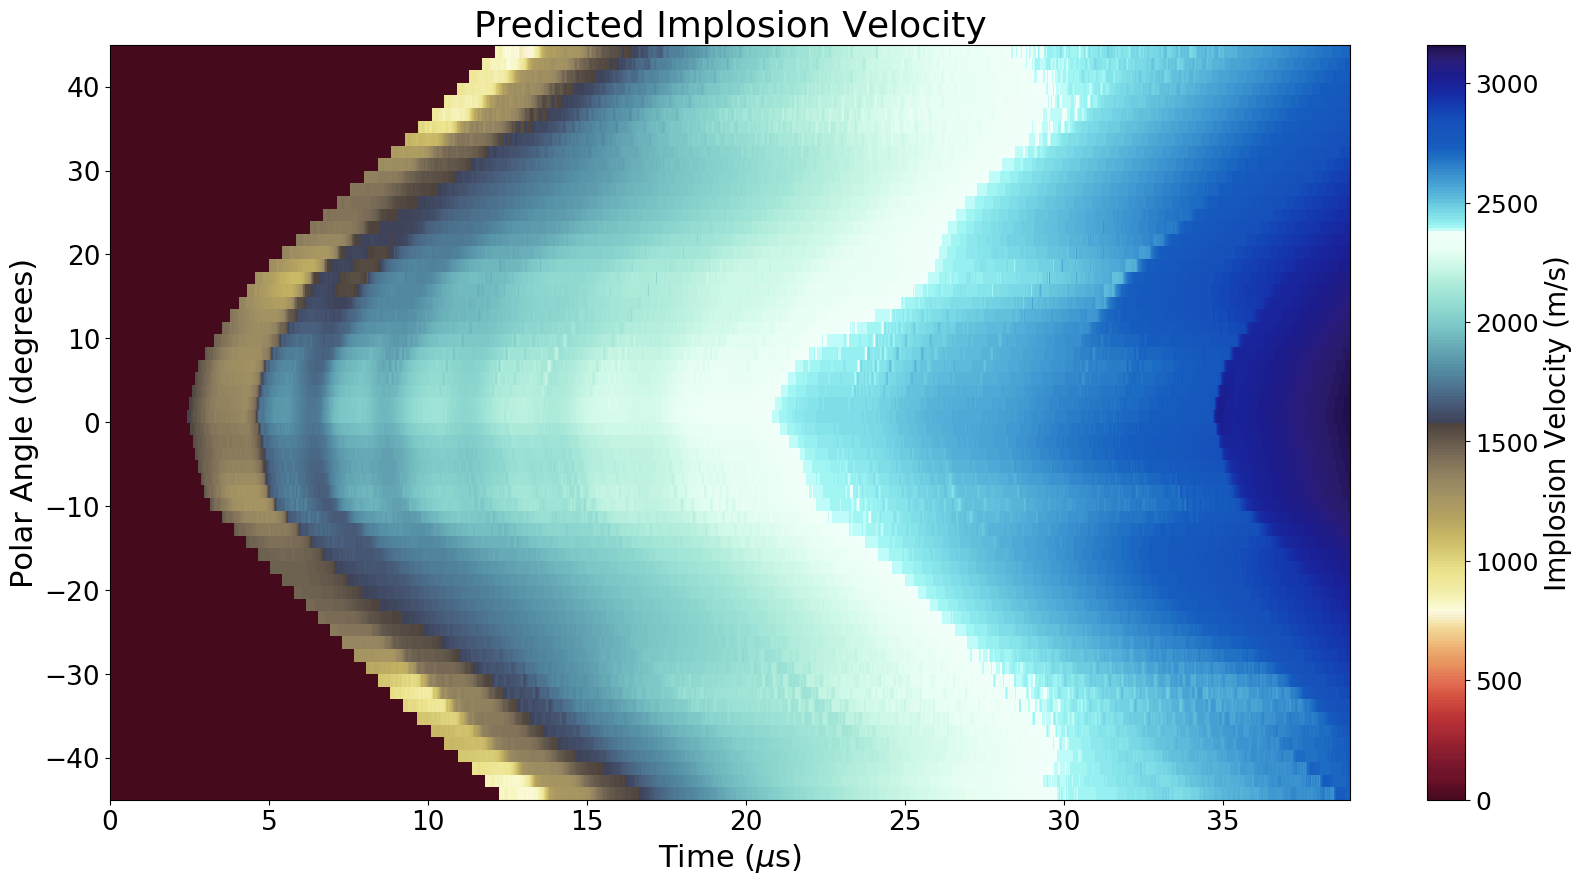

In [77]:
fig  = plt.figure(figsize=(20, 10),dpi=100)
fig.add_subplot(111)
plt.imshow(1000*surf_opt.vel_mean[surf_opt.n_probe:surf_opt.n_angle,:], 
           cmap = mycmap, aspect='auto',extent=[0,np.max(surf_opt.times),90,-90])#, interpolation = 'bilinear')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_ylabel('Implosion Velocity (m/s)', rotation=90, fontsize=20)
plt.xlabel(r"Time ($\mu$s)",fontsize=22)
plt.ylabel("Polar Angle (degrees)",fontsize=22)
plt.title("Predicted Implosion Velocity", fontsize=26)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.ylim([-45,45])
plt.show()

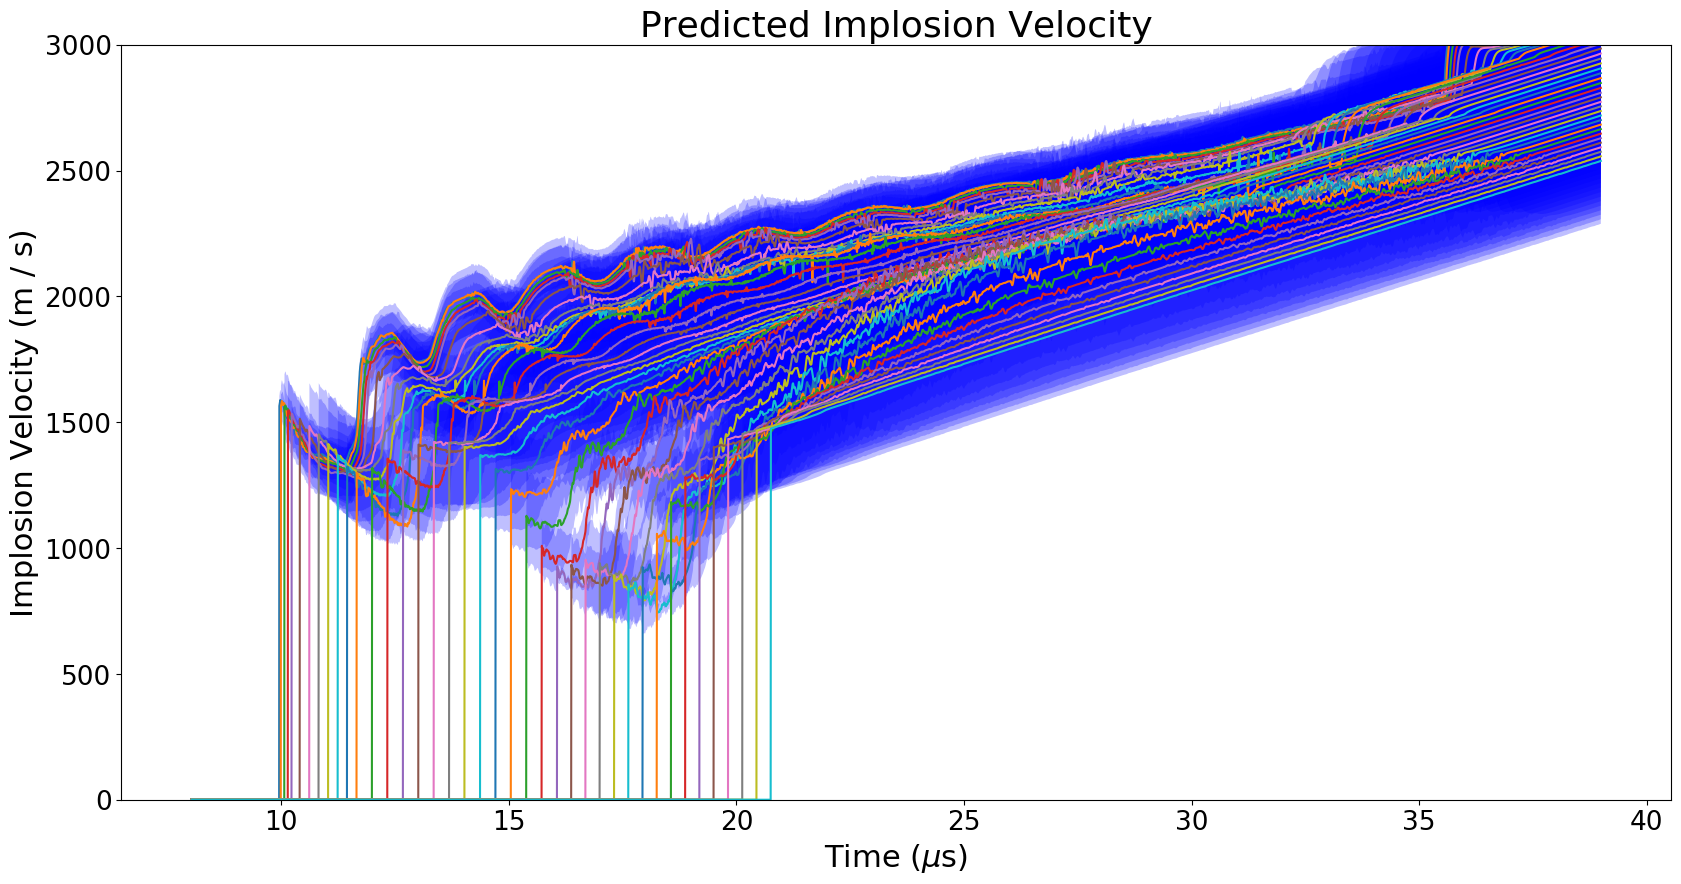

In [65]:
fig  = plt.figure(figsize=(20, 10),dpi=100)
fig.add_subplot(111)
for jj in range(60,100):
# for jj in range(0,surf_opt.n_pred,5):
    plt.plot(surf_opt.times, 1000*surf_opt.vel_mean[surf_opt.n_probe + jj,:])
    plt.fill_between(surf_opt.times,
                     1000*(surf_opt.vel_mean[surf_opt.n_probe + jj, :] + 2 * np.sqrt(surf_opt.vel_var[surf_opt.n_probe + jj,:])),
                     1000*(surf_opt.vel_mean[surf_opt.n_probe + jj, :] - 2 * np.sqrt(surf_opt.vel_var[surf_opt.n_probe + jj,:])),
                     alpha       = 0.25, 
                     facecolor   = 'b', 
                     interpolate = True)
plt.xlabel(r"Time ($\mu$s)",fontsize=22)
plt.ylabel(r"Implosion Velocity (m / s)",fontsize=22)
plt.title("Predicted Implosion Velocity", fontsize=26)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.ylim([0,3000])
plt.show()

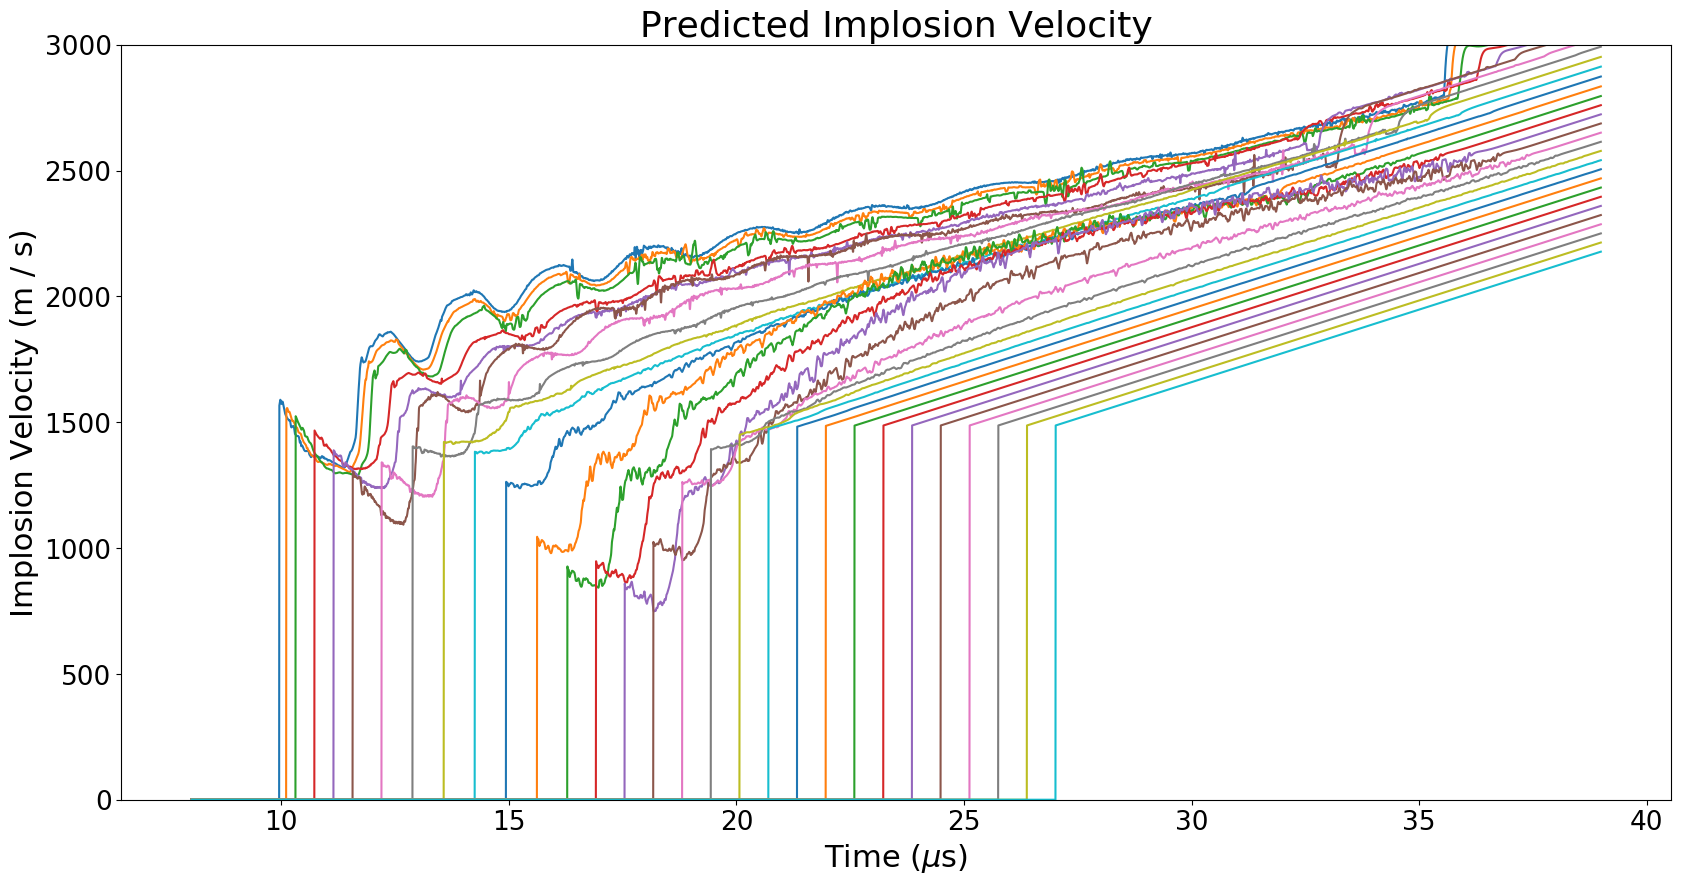

In [65]:
fig  = plt.figure(figsize=(20, 10),dpi=100)
fig.add_subplot(111)
for jj in range(30,60):
    plt.plot(surf_opt.times, 1000*surf_opt.vel_mean[surf_opt.n_probe + jj,:])
plt.xlabel(r"Time ($\mu$s)",fontsize=22)
plt.ylabel(r"Implosion Velocity (m / s)",fontsize=22)
plt.title("Predicted Implosion Velocity", fontsize=26)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.ylim([0,3000])
plt.show()

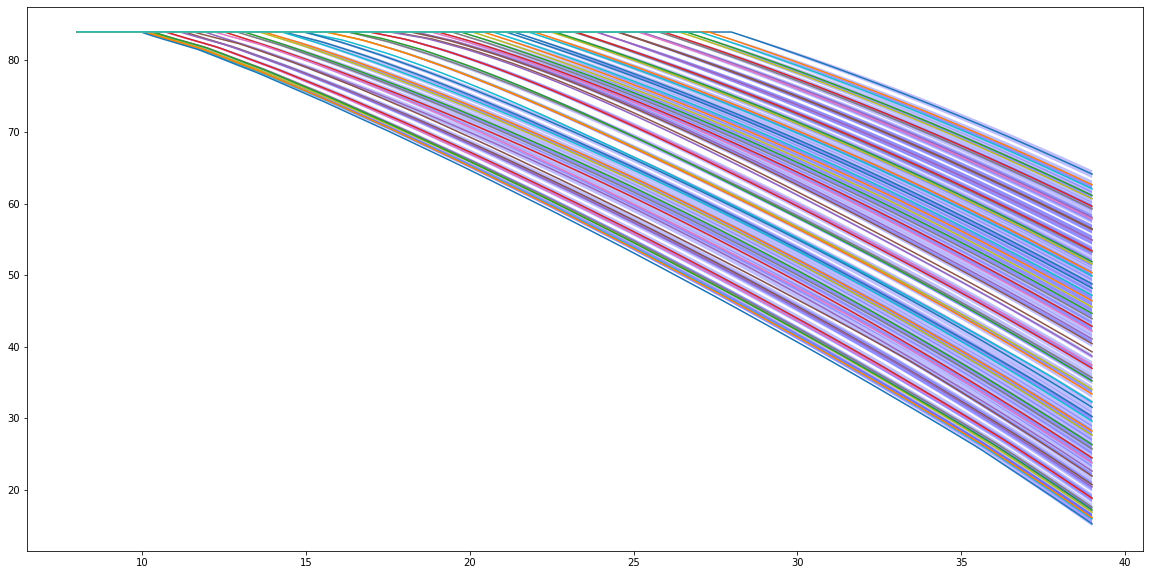

In [29]:
fig  = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

pangs = surf_opt.n_probe + np.arange(surf_opt.n_pred)
for jj in pangs:
    ax.plot(surf_opt.times, surf_opt.pos_mean[jj,:])
    ax.fill_between(surf_opt.times,
                    surf_opt.pos_mean[jj, :] + 2 * np.sqrt(surf_opt.pos_var[jj,:]),
                    surf_opt.pos_mean[jj, :] - 2 * np.sqrt(surf_opt.pos_var[jj,:]),
                    alpha       = 0.25, 
                    facecolor   = 'b', 
                    interpolate = True)

plt.show()